# Chapter 2

## Figure 2.1
First we seek to describe the n-armed bandit problem, in which a series of levers are presented to a user with various distributions of rewards behind each. We have no preconceived notion of the distributions of these rewards, we must test them to try and get an idea. Moreover, there is some noise associated with each pull of the lever, therefore we must develop an idea of the "average" output of each one. We do this by experimenting with each lever then creating an estimate of the the means, updating the estimates iteratively as we pull the levers to try and determine the actual value of the means of the levers. 

For this chapter, we develop the *10-armed testbed,* a model that we will use henceforth in this chapter. First we will define the distributions of the rewards. We define them by drawing 10 samples from a $N(0,1)$ distribution, which are our expected outputs from each lever, then creating a $N(0,1)$ reward distribution around each mean, as shown below. 

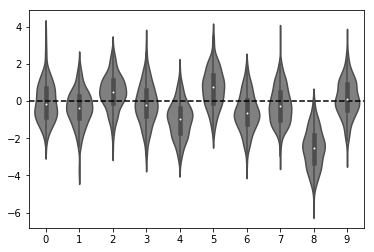

In [3]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.violinplot(data = np.random.normal(0,1,10) + np.random.randn(200, 10), color = 'gray')
plt.axhline(y=0, color='black', linestyle='--', lw= 1.5)

In [4]:
def k_bandit_testbed(arms, time, runs, eps, stationary = True, 
                      constant_step = False, step_size = .1, 
                      optimistic = False, opt_mean = 5,
                      UCB = False, c = 2):
    
    final_reward = [[] for i in range(0,len(eps))]
    optimal_action = [[] for i in range(0,len(eps))]
    for k in range(len(eps)):
        Rewards = np.zeros(time)
        OptimalAction = np.zeros(time)
        for i in range(runs):
            q_star = np.random.normal(0,1,arms)
            bestAction = np.argmax(q_star)
            q_est = np.zeros(arms)
            if optimistic:
                q_est = np.repeat(float(opt_mean), arms)
            counts = np.zeros(arms)
            rew = []
            optimalAction = []
            for j in range(0,time):
                optimal_count = 0
                if eps[k] > np.random.random(): 
                    action = np.random.randint(arms)
                else:
                    action = np.argmax(q_est)
                if UCB:
                    action = np.argmax(q_est + c*np.sqrt(np.log(time+1)/(counts+1)))
                if action == bestAction:
                    optimal_count = 1
                reward = q_star[action] + np.random.normal(0,1)
                counts[action] +=1
                if constant_step:
                    q_est[action] += step_size*(reward - q_est[action])
                else:
                    q_est[action] += (1/counts[action])*(reward - q_est[action])
                if not stationary:
                    q_star += np.random.normal(0,.01,arms)
                    bestAction = np.argmax(q_star)
                rew.append(reward)
                optimalAction.append(optimal_count)
            Rewards += rew
            OptimalAction += optimalAction
        
        final_reward[k] = Rewards/runs
        optimal_action[k] = OptimalAction/runs
    return final_reward, optimal_action

## Figure 2.2
Here we test the *10-armed testbed* on various values of $\epsilon$, which is a factor that determines how much expolration of the model space is done vs. the expolitation of information that the algorithm has already determined.

In [5]:
eps = [0, .01, .1]
reward, action = k_bandit_testbed(10, 1000, 2000, eps)

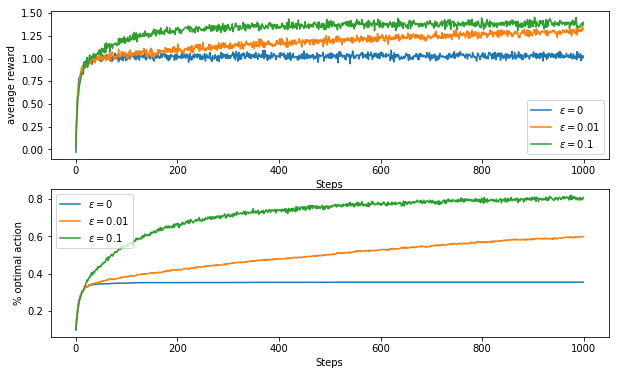

In [6]:
fig = plt.subplots(figsize=(10, 6))
plt.figure(1)
plt.subplot(211)
for i in range(len(reward)):
    plt.plot(reward[i], label = "$\epsilon = $" +str(eps[i]))
plt.legend()
plt.xlabel('Steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(212)
for i in range(len(action)):
    plt.plot(action[i], label = "$\epsilon = $" +str(eps[i]))
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()


We see here that $\epsilon = 0$, also known as the *greedy* method, consistantly derives the lowest average reward and optimal action taken. This is because the greedy method simply takes the maximum of the rewards that it has already seen and continues to take that action. A real-life example would be seeing that one lever offers $1 as a reward, and since that is the highest reward you have seen yet you simply continue to pull that lever and never bother to try any of the others. In the optimization sense, we have found a local maxima, and the greedy will continue to exploit that maxima without searching for a way out of the basin. 

When phrased in this way, the potential drawbacks to this approach are very obvious. This is where the $\epsilon$-greedy approach comes in. This approach takes the greedy action some number of times based on a predetermined probability. However, some percentage of the time, say 10% of the time, $\epsilon = 0.1$, the algorithm will try a different arm. If the output is higher, it will begin to exploit the new, higher arm instead. If not, it will return to the original. 

The value of $\epsilon$ will determine how long it will take for your testbed to find the "true" max. As seen above, the $\epsilon = 0.1$ approach found the optimal actions in the least amount of time, and as a result had a higher initial average reward. But, if we observe the lower value of $\epsilon$, $\epsilon = 0.01$, we see that it continues to gradually increase in the average number of optimal actions. As a result, the average reward of the $\epsilon = 0.01$ continues to increase and will eventually surpass the average reward of $\epsilon = 0.1$ as both reach their asymptotic values, due to the inherit losses in average reward from the number of times $\epsilon = 0.1$ experiments instead of exploits. 

## Exercise 2.5
In this exercise we explore what happens to the optimal actions and rewards when we change the original *10-armed testbed* model to one with non-stationary means. To do this, we modify the code to add a $N(0, 0.01)$ perturbation to the expected values of the levers with each action taken. 

In [65]:
reward1, action1 = k_bandit_testbed(10, 1000,2000, [0.1])
reward2, action2 = k_bandit_testbed(10, 1000,2000, [0.1], stationary = False)
reward3, action3 = k_bandit_testbed(10, 1000,2000, [0.1], stationary = False, constant_step = True, step_size = 0.01)

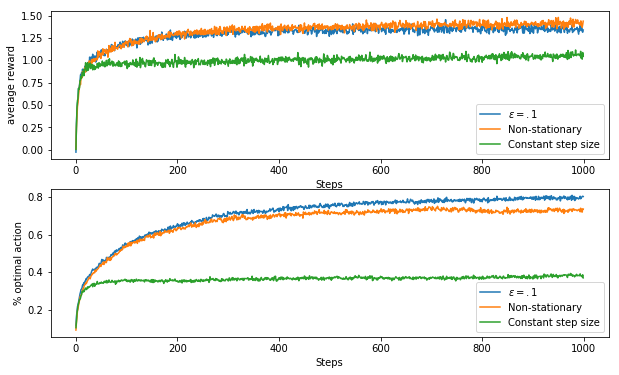

In [66]:
fig = plt.subplots(figsize=(10, 6))
plt.figure(1)
plt.subplot(211)
plt.plot(reward1[0], label = "$\epsilon = .1$")
plt.plot(reward2[0], label = "Non-stationary")
plt.plot(reward3[0], label = "Constant step size")
plt.xlabel('Steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(212)
plt.plot(action1[0], label = "$\epsilon = .1$")
plt.plot(action2[0], label = "Non-stationary")
plt.plot(action3[0], label = "Constant step size")
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

Since the means are changing in the non-stationary model, we would expect to find the optimal action less as time continues, since now the optimal action can change without the $\epsilon$-greedy algorithm knowing that it is no longer actually making the "greedy" decision. Once the "greedy" action changes, it can be some time before the algorithm determines which action is optimal again, especially with a lower value of $\epsilon$. We see this above.

In addition, we evaluate the idea of taking a constant step size action-value method in this example, as opposed to the "running average" described in the text in section 2.4. This results in a very low reward and optimal action average, resembling the greedy approach from 2.2 above. 

However, dont count out the constant step size yet, we'll return to that later to see how useful it can be in other types of bandit problems. 


## Figure 2.3
Here we evaluate the effect of optimistically estimating the means at the initialization of the algorithm. Its worth clarifying that we arent increasing the expected value of the individual rewards, but rather optimistically biasing the expected rewards at the beginning. Returning to our slot machine example, this would be the equivilant of walking up to the machine expecting each lever to deliver you $5, then updating your estimates as you experiment. 

In [67]:
rewardOpt, actionOpt = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, optimistic = True)
rewardReal, actionReal = k_bandit_testbed(10, 1000, 2000, [0.1], constant_step = True)

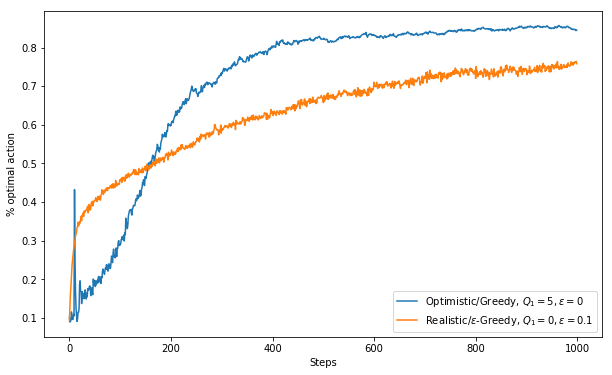

In [68]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(actionOpt[0], label = "Optimistic/Greedy, $Q_{1} = 5, \epsilon = 0$")
plt.plot(actionReal[0], label = "Realistic/$\epsilon$-Greedy, $Q_{1} = 0, \epsilon =0.1$")
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

We see here that optimistically biasing the estimates results in a markedly higher (and faster) optimal action discovery than an $\epsilon$-greedy approach. Taking the optimistic/greedy combination effectively creates a "top-down" view of the actions as far as the reward is concerned, with each timestep as the lever is pulled it reduces the estimates of the arms that have a lower expected reward. The greedy algorithm simply switches around until it locates the arm that decreases the lowest. This arm, by definition, is the optimal action. The realistic/$\epsilon$-greedy approach, by contrast, is a "bottom-up" approach, in which a reasonable amount of experimenting is needed to derive the actual optimal action. This is seen graphically above.

## Figure 2.4 


Here we explore the concept of the "Upper Confidence Bound," and approach that allows us to minimize the variance of potentially maximizing actions, while simultaneously ensuring that we test all possible actions for their reward maximization potential. Due to the nature of the UCB update step, actions with a lower expected reward will be selected less as the iterations continue.

The UCB uses a similar 'argmax" approach to determine which action to be taken, however here the action is chosen based on the formula

$A_{t}$ = argmax$ \bigg[ Q_{t}(a) + c\sqrt{\frac{log(t)}{N_{t}(a)}}\bigg]$

Where $Q_{t}(a)$ is the estimate of the rewards of each arm at time $t$.

In [69]:
rewardUCB, actionUCB = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, UCB = True)
rewardEps, actionEps = k_bandit_testbed(10, 1000, 2000, [0.1])

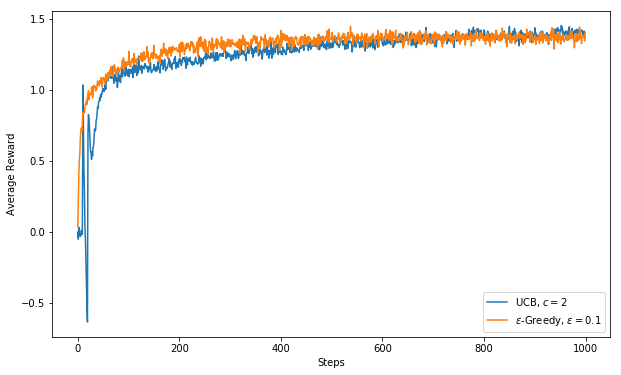

In [70]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(rewardUCB[0], label = "UCB, $c=2$")
plt.plot(rewardEps[0], label = "$\epsilon$-Greedy, $\epsilon =0.1$")
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

We see here that the UCB approach reaches a higher maximum reward than the $\epsilon$-greedy. This is because the $\epsilon$-greedy algorithm doesnt reduce the chance that another action is potentially better than the one currently being chosen over a time horizon, while the UCB update reduces the chance of selecting a sub-optimal action with each timestep. Again, the exploration vs. exploitation tradeoff causes the $\epsilon$-greedy algorithm to have a lower average reward. 

# Figure 2.5
Here we evaluate the efficacy of the "gradient bandit" algorithm

In the gradient bandit problem, the action is not chosen by taking the max of a vector of expected rewards, as has been done in all the previous search techniques. Rather, the probability of taking a specific action is given by the Boltzmann distribution:

Pr$\left\{A_{t} = a\right\}$ = $ \pi_{t}(a) $ =  $\frac{e^{H_{t}(a)}}{\sum\nolimits_{b=1}^k e^{H_{t}(b)}}$

$H_{t}$ in this equation is considered  a "preference" of an action occurring, and is updated with each timestep using the equation

$H_{t+1}(A_{t}) = H_{t}(A_{t}) + \alpha(R_{t} - \bar{R_{t}})(1 -\pi_{t}(a))$

where $\alpha$ is the step size parameter and $\bar{R_{t}}$ is the average reward of all the previous timesteps. This mimics stochastic gradient ascent, in which the reward at a timestep is compared with the expected, and the preference function $H_{t}$ incremented or decremented by some some amount. This amout depends on the difference of the expected vs. the observed and the step size parameter $\alpha$.

$\bar{R_{t}}$ serves as a "baseline" in this context, allowing the algorithm to have an incrementally updated average reward to compare the reward at a specific timestep. 

In [8]:
def gradient_bandit(arms, time, runs, step_size, avgreward = 4, 
                    GradientBase = True, Stationary = True):
    final_reward = [] 
    optimal_action = [] 
    OptimalAction = np.zeros(time)
    Rewards = np.zeros(time)
    for i in range(runs):
        q_star = np.random.normal(avgreward,1,arms)
        bestAction = np.argmax(q_star)
        H = np.zeros(arms)
        counts = np.zeros(arms)
        rew = []
        pi = np.zeros(arms)
        optimalAction = []
        Rbar = 0.0
        for j in range(0,time):
            optimal_count = 0
            pi = np.exp(H)/np.sum(np.exp(H))
    
            action = np.random.choice(arms, p=pi)
            if action == bestAction:
                optimal_count = 1
            reward = q_star[action] + np.random.normal(0,1)
            counts[action] +=1
            Rbar = (j)/(j+1)*Rbar + reward/(j+1)
            ones = np.array(np.repeat(1,arms))
            ones[action] = 1
            one = np.zeros(arms)
            one[action] = 1
            if GradientBase:
                baseline = Rbar
            else:
                baseline = 0
            H += step_size*(reward - baseline)*(one-pi)
            rew.append(reward)
            optimalAction.append(optimal_count)
            if not Stationary:
                q_star += np.random.normal(0,0.01,arms)
                bestAction = np.argmax(q_star)
        Rewards += rew
        OptimalAction += optimalAction
    
    final_reward = Rewards/runs
    optimal_action = OptimalAction/runs
    return final_reward, optimal_action

In [72]:
final_reward1, optimal_action1 = gradient_bandit(10, 1000,1000, .1)
final_reward2, optimal_action2 = gradient_bandit(10, 1000,1000, .4)
final_reward3, optimal_action3 = gradient_bandit(10, 1000,1000, .1, GradientBase = False)
final_reward4, optimal_action4 = gradient_bandit(10, 1000,1000, .4, GradientBase = False)

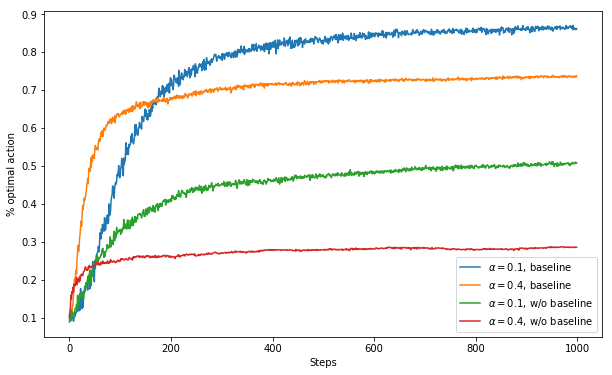

In [73]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(optimal_action1, label = r"$\alpha = 0.1$, baseline")
plt.plot(optimal_action2, label = r"$\alpha = 0.4$, baseline")
plt.plot(optimal_action3, label = r"$\alpha = 0.1$, w/o baseline")
plt.plot(optimal_action4, label = r"$\alpha = 0.4$, w/o baseline")
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

Here we have a comparison of gradient bandits, some with the baseline $\bar{R_{t}}$ and others with the baseline set to 0. The above plot is created using a reward distribution of $N(4,1)$, as opposed to mean 0 rewards. Setting the removing the baseline (e.g. setting $\bar{R_{t}}=0$ for each time step) means that the algorithm cannot use the past information to determine whether the observed rewards is actually good or bad in comparison to the expected reward, resulting in very suboptimal performance. 

The baseline approach immediately adapts to a higher or lower expected average return since the expected reward is learned as time proceeds. This allows the gradient bandit algorithm to determine which levers do, in fact, deliver the highest reward on average and exploit those levers. 

# Figure 2.6

Here we compare the average expected return over 1000 interations of each different type of bandit algorithm discussed above, while verying their unique parameters to determine their efficacy. 

In [10]:
rewards = []
for d in np.arange(-7,-1):
    rew, act = k_bandit_testbed(10, 1000, 2000, [(2**float(d))])
    rewards.append(sum(rew[0]))
eps = np.array(rewards)/1000
    

rewards = []
exp = np.arange(-5.,3)
C= 2**exp
for d in C:
    rew, act = gradient_bandit(10, 1000, 2000, d, avgreward = 0)
    rewards.append(sum(rew))
grad = np.array(rewards)/1000


rewards = []
exp = np.arange(-4.,3)
C= 2**exp
for d in C:
    rew, act = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, step_size = 0.10, UCB = True, c = d)
    rewards.append(sum(rew[0]))
UCB = np.array(rewards)/1000


rewards = []
exp = np.arange(-2.,3.)
C= 2**exp
for d in C:
    rew, act = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, step_size = 0.10, optimistic = True, opt_mean = d)
    rewards.append(sum(rew[0]))
opt = np.array(rewards)/1000

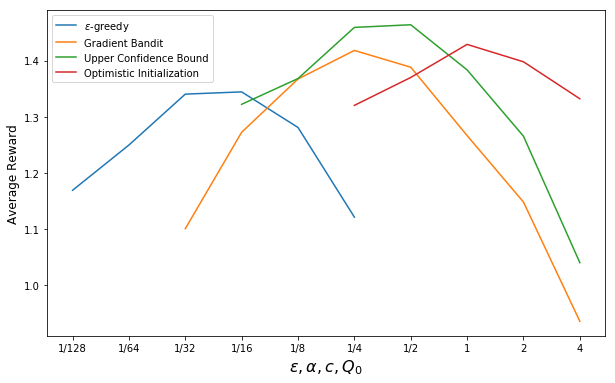

In [75]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(range(6), eps, label = "$\epsilon$-greedy")
plt.plot(range(2,10), grad, label = 'Gradient Bandit')
plt.plot(range(3,10), UCB, label = 'Upper Confidence Bound')
plt.plot(range(5,10), opt, label = 'Optimistic Initialization')
plt.xticks(range(10), ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'])
plt.xlabel(r'$\epsilon, \alpha, c, Q_{0}$', size = 16)
plt.ylabel('Average Reward', size = 12)
plt.legend()
plt.show()

We can see here that there is in fact a "sweet spot" for each of the algorithms that maximizes the expected return, however in this instance that value is determined emperically by experimentation. We notice that the optmisitcally-biased algorithm and UCB consistantly deliver the highest average reward over the parameter spaces defined below. 

# Exercise 2.8

Here we recreate the above plot, however we modify the underlying reward distributions to have non-stationary means.

In [17]:
rewards = []
for d in np.arange(-7,-1):
    rew, act = k_bandit_testbed(10, 5000, 2000, [(2**float(d))], stationary = False)
    rewards.append(sum(rew[0]))
eps = np.array(rewards)/5000
    

rewards = []
exp = np.arange(-5.,3)
C= 2**exp
for d in C:
    rew, act = gradient_bandit(10, 5000, 2000, d, avgreward = 0, Stationary = False)
    rewards.append(sum(rew))
grad = np.array(rewards)/5000


rewards = []
exp = np.arange(-4.,3)
C= 2**exp
for d in C:
    rew, act = k_bandit_testbed(10, 5000, 2000, [0], stationary = False, constant_step = True, 
                                step_size = 0.10, UCB = True, c = d)
    rewards.append(sum(rew[0]))
UCB = np.array(rewards)/5000


rewards = []
exp = np.arange(-2.,3.)
C= 2**exp
for d in C:
    rew, act = k_bandit_testbed(10, 5000, 2000, [0], stationary = False, constant_step = True, 
                                step_size = 0.10, optimistic = True, opt_mean = d)
    rewards.append(sum(rew[0]))
opt = np.array(rewards)/5000

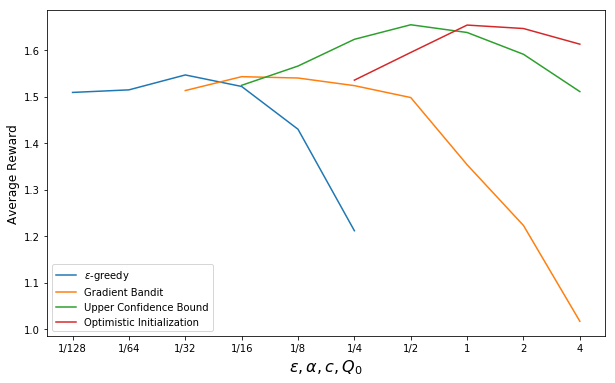

In [18]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(range(6), eps, label = "$\epsilon$-greedy")
plt.plot(range(2,10), grad, label = 'Gradient Bandit')
plt.plot(range(3,10), UCB, label = 'Upper Confidence Bound')
plt.plot(range(5,10), opt, label = 'Optimistic Initialization')
plt.xticks(range(10), ['1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'])
plt.xlabel(r'$\epsilon, \alpha, c, Q_{0}$', size = 16)
plt.ylabel('Average Reward', size = 12)
plt.legend()
plt.show()

Here we see that the average reward for the non-stationary means is actually reasonably higher, which is consistant with the intuition that the algorithms will detect shifts in the optimal action and begin to exploit those actions once discovered. We again notice that the UCB algorithm and the optimistic initialization return the highest rewards, but its interesting to note that the $\epsilon$-greedy algorithm and the gradient bandit both start out fairly flat, even at low values of their respective "tuning parameter." This is interesting to note since the intuitive response to the question of variable reward distributions with low "learning" parameters (such as $\epsilon$ or $\alpha$) would be that it would be *harder* for the algorithm to find the optimal action (and thus have a lower reward), however we see here that this is not the case and those algorithms are able to detect the higher reward distributions even at smaller parameter settings. 

### A Note on Step Size

An interesting note to make is the effect of step size on how quickly the algorithm finds the optimal solution (or if it finds the optimal solution at all). The most notable of these is the effect on the optimistically biased algorithm, which is shown here.

First, we run the algorithm with a step size of $\alpha = 0.01$ and another at $\alpha = 0.1$, and plot the data. 

In [79]:
rewardOpt, actionOpt = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, optimistic = True)
rewardOpt2, actionOpt2 = k_bandit_testbed(10, 1000, 2000, [0], constant_step = True, 
                                          step_size = 0.01, optimistic = True)

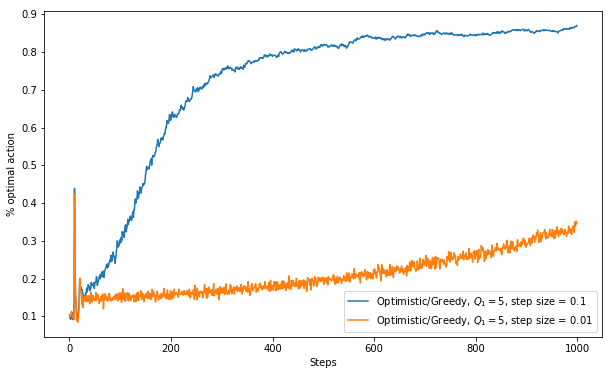

In [81]:
fig = plt.subplots(figsize=(10, 6))
plt.plot(actionOpt[0], label = "Optimistic/Greedy, $Q_{1} = 5$, step size = 0.1")
plt.plot(actionOpt2[0], label = "Optimistic/Greedy, $Q_{1} = 5$, step size = 0.01")
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

The desparity here is obvious. The optimistic/greedy implementation here finds the optimal solution quite quicky when $\alpha = 0.1$, however on the 1000 step horizon $\alpha = 0.01$ clearly performs signifigantly worse. 

But wait, theres a signifigant caveat (as always).


In [30]:
rewardOpt, actionOpt = k_bandit_testbed(10, 10000, 2000, [0], constant_step = True, 
                                          step_size = 0.05, optimistic = True)
rewardOpt2, actionOpt2 = k_bandit_testbed(10, 10000, 2000, [0], constant_step = True, 
                                          step_size = 0.025, optimistic = True)
rewardOpt3, actionOpt3 = k_bandit_testbed(10, 10000, 2000, [0], constant_step = True, 
                                          step_size = 0.005, optimistic = True)

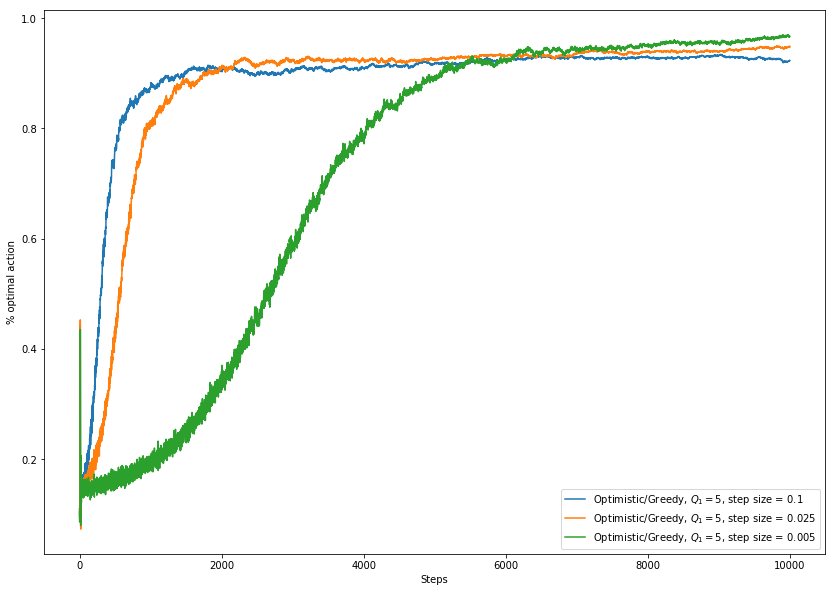

In [33]:
fig = plt.subplots(figsize=(14, 10))
plt.plot(actionOpt[0], label = "Optimistic/Greedy, $Q_{1} = 5$, step size = 0.1")
plt.plot(actionOpt2[0], label = "Optimistic/Greedy, $Q_{1} = 5$, step size = 0.025")
plt.plot(actionOpt3[0], label = "Optimistic/Greedy, $Q_{1} = 5$, step size = 0.005")
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

Here we evaluate the same algorithms on a timeline of 10,000 steps. On an infinite (or just signifigantly longer) horizon the smaller step size allows us to get closer to employing some very nice asymoptotics that typically can't be seen on a finite horizon. Those asymptotics allow us to approach the 100% optimal action on 100% of the iterations, **provided there is sufficient time to get there**. This is shown graphically above using decreasing step size  parameters of 0.01. 0.025, and 0.005. 